In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation

import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd

In [87]:
class Trial:
    def __init__(
        self,
        A, # adjacency matrix
        N,
        M,
        n_trials,
        memory_length,
        seed
    ):
        self.A = A
        self.N = N
        self.M = M
        self.n_trials = n_trials
        self.memory_length = memory_length
        self.rng = np.random.default_rng(seed)

        # minimum number of friends who went last time if it wasn't full
        self.alphas = np.ones((N, n_trials), dtype=int) * 2 
        # minimum number of friends who went last time if it was too full
        self.betas = np.ones((N, n_trials), dtype=int) * 5
        # weeks back to look when making decision
        self.gammas = np.zeros((N, n_trials), dtype=int)
        # random probability of going
        self.epsilons = np.ones((N, n_trials)) * 0.03
        # self.epsilons = np.ones((N, n_trials)) * 0
        # random probability of not going
        # nonzero delta could completely destabilize an arrangement
        # I think?
        self.deltas = np.zeros((N, n_trials)) 

        # each node needs to remember the last k weeks
        # options- we could target interventions to particular 
        # circumstances, e.g. reduce minfriends if you are never going
        # or we could just let things evolve randomly
        # let's start with random because yolo
        self.memory = np.full((N, memory_length), np.nan)

        # initial conditions
        self.Xnp = np.full((N, n_trials), np.nan)


        # track previous weeks' neighbor counts to avoid
        # redoing multiplication
        self.nc = np.full((N, n_trials), np.nan)
    
    
    def apply_thresholds(self, params, mask, X, gamma):
        #print("X: ")
        #print(X)
        if self.t - gamma < 0:
            return X
        
        for p in np.unique(params[:, self.t]):
            #print(p)
            mask = np.intersect1d(mask, np.where(params[:,self.t] == p))
            #print(len(mask))
            X[mask] = self.nc[mask, self.t - gamma] > p
            #print("New X: ")
            #print(X)
        return X
    
    
    def run(self):
        # initial conditions
        X = self.rng.uniform(size=(self.N,)) < 0.3
        self.Xnp[:,0] = X
        self.nc[:,0] = self.A.dot(X)
        
        self.t = 0
        
        while self.t < self.n_trials-1:

            # run backward computation for each gamma value
            for gamma in np.unique(self.gammas[:, self.t]):
                mask = np.where(self.gammas[:, self.t] == gamma)[0]

                if X.sum() < self.M:
                    X = self.apply_thresholds(self.alphas, mask, X, gamma)
                else:
                    X = self.apply_thresholds(self.betas, mask, X, gamma)

            # add noise
            X += self.rng.uniform(size=self.N) < self.epsilons[:,self.t]
            X = np.bitwise_and(X, self.rng.uniform(size=self.N) > self.deltas[:,self.t])

            self.t += 1
            # save this week's atttendance
            self.Xnp[:,self.t] = X
            # save number of neighbors that went this week
            self.nc[:,self.t] = self.A.dot(X)
            
            
    def plot_attendance(self):
        plt.plot(T.Xnp.sum(axis=0))

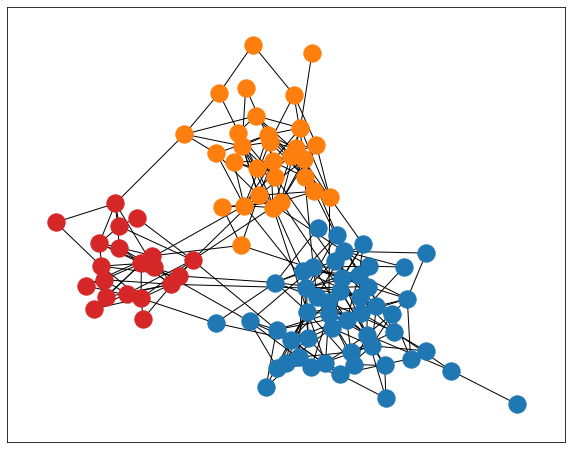

In [89]:
plt.rcParams["figure.figsize"] = (10,8)

sizes = [20, 50, 30]
probs = [[0.25,0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 1/6]]
G = nx.stochastic_block_model(sizes, probs, seed=30)
A = nx.convert_matrix.to_numpy_matrix(G)

pos = nx.spring_layout(G, seed=3113794652)
nx.draw_networkx_nodes(G, pos, nodelist=range(0,sizes[0]), node_color="tab:red")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0], sizes[0]+sizes[1]), node_color="tab:blue")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0]+sizes[1], 100), node_color="tab:orange")
nx.draw_networkx_edges(G, pos)

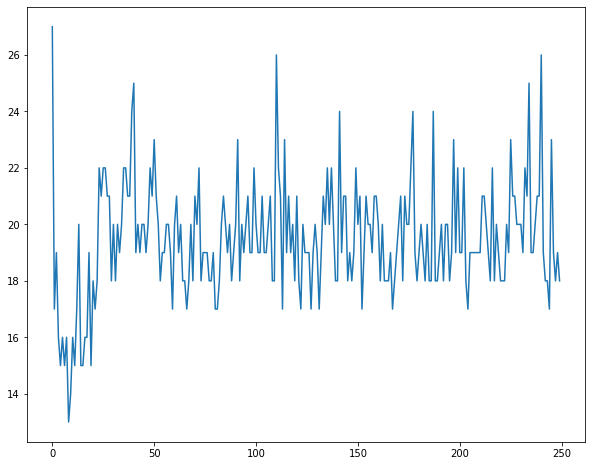

In [90]:
T = Trial(A, 100, 60, 250, 10, 1234567)
T.run()
T.plot_attendance()

In [91]:
# TODO sanity check
t = 73

T.Xnp[:,t]

array([1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [92]:
X_det = T.nc[:,t-1] > T.alphas[:,t-1]
T.Xnp[:,t] - X_det

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [93]:
eps = []
for t in range(1,250):
    X_det = T.nc[:,t-1] > T.alphas[:,t-1]
    eps.append((T.Xnp[:,t] - X_det).sum())
    
np.array(eps).mean()

2.4578313253012047

(array([ 76., 118.,  42.,  12.,   1.]),
 array([0. , 1.8, 3.6, 5.4, 7.2, 9. ]),
 <BarContainer object of 5 artists>)

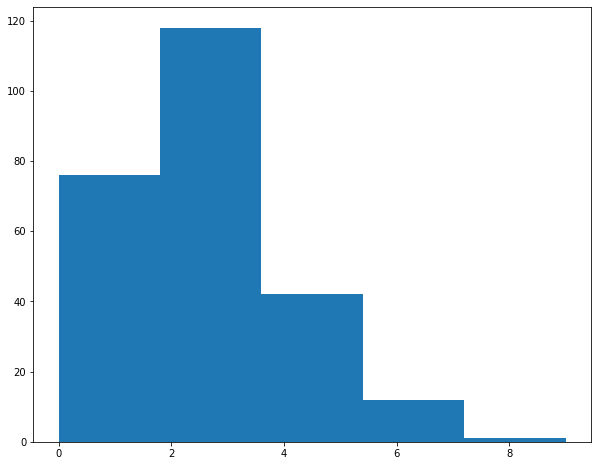

In [94]:
plt.hist(np.array(eps), bins=5)

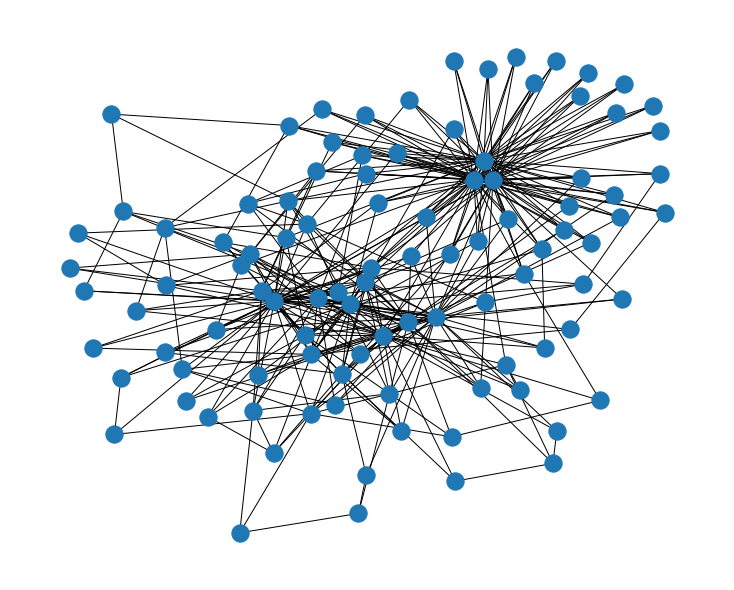

In [95]:
# TODO: configuration model
def truncated_power_law(gamma, k_0, n, size=None):
    """
    Generate a sample of size *size* from a power law distribution
    with mininmum *k_0*, maximum *n*, and power *gamma*
    """
    k_0=np.float64(k_0)
    gamma=np.float64(gamma)
    n=np.float64(n)
    
    if size:
        U = rng.uniform(size=size)
    else:
        U = rng.uniform()
        
    return (
        (k_0**(1-gamma) - 
             ( k_0**(1-gamma) - n**(1-gamma) ) * U 
        )**(1/(1-gamma))
    )

def generate_chung_lu(k):
    n = len(k)

    k_mean = k.mean()
    # k_mean times is twice the expected number of edges
    # this will be the denominator of all edge probabilities
    m2 = k_mean * n

    # initialize adjacency matrix
    A = np.zeros((n,n),dtype=int)
    choices = rng.random(n*(n-1) // 2)
    choice_i = 0
    
    for i in range(n):
        for j in range(i+1,n):
            # no self loops
            if i == j:
                continue
                
            # compute probability of edge
            p = min(
                (k[i] * k[j] / m2,
                1))
            
            # generate edge
            if choices[choice_i] < p:
                A[i,j] = 1
                A[j,i] = 1
            
            choice_i += 1
                
    return A

rng = np.random.default_rng(2357111)

gamma = 2.4
k_0 = 2
n = 100
size=100

k = truncated_power_law(gamma, k_0, n, size=size).astype(int)
k.sort()

A = generate_chung_lu(k)
A.sum(axis=1).mean()

k = A.sum(axis=0)
disco = np.where(k<3)

for i in disco:
    for j in rng.choice(n, size=3):
        A[i,j] = 1
        A[j,i] = 1

G = nx.convert_matrix.from_numpy_array(A)
pos = nx.spring_layout(G, seed=3113794652)

nx.draw(G,pos)

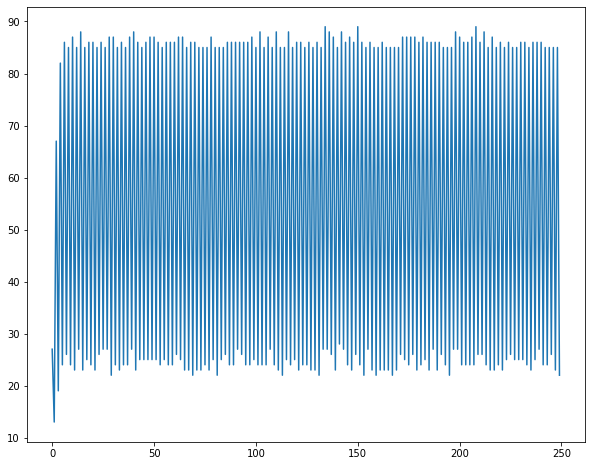

In [96]:
T = Trial(A, 100, 60, 250, 10, 1234567)
T.run()
T.plot_attendance()

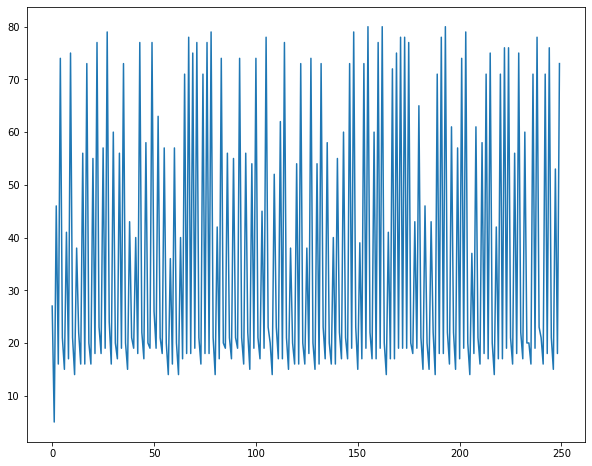

In [97]:
T = Trial(A, 100, 20, 250, 10, 1234567)
T.run()
T.plot_attendance()

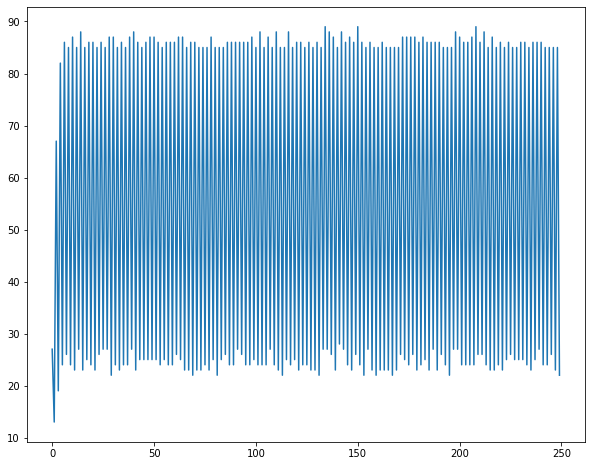

In [98]:
T = Trial(A, 100, 30, 250, 10, 1234567)
T.run()
T.plot_attendance()

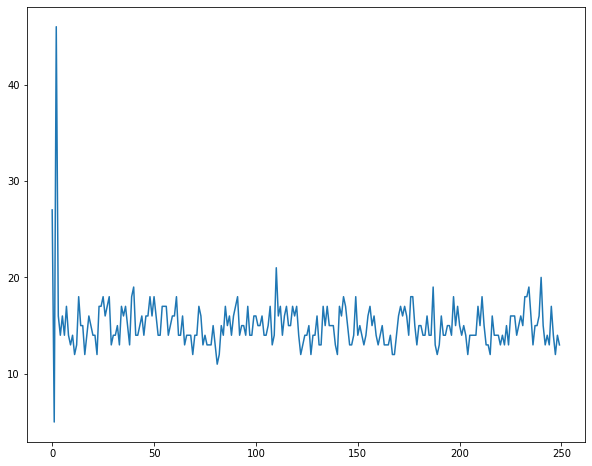

In [99]:
T = Trial(A, 100, 10, 250, 10, 1234567)
T.run()
T.plot_attendance()